In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

load MNIST dataset with transformations

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

distort the images to show the effect of denoising

In [4]:
# define a function to create a Gaussian blur kernel (PSF)
def gaussian_kernel(size=5, sigma=1.0):
    """generates a 2D Gaussian kernel for simulating PSF blur."""
    x = torch.arange(-size // 2 + 1., size // 2 + 1.)
    y = torch.arange(-size // 2 + 1., size // 2 + 1.)
    x_grid, y_grid = torch.meshgrid(x, y, indexing='ij')
    kernel = torch.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
    kernel /= kernel.sum()  # normalize
    return kernel.view(1, 1, size, size)  # shape: (1,1,H,W) for conv2d

def blur_and_noise(imgs, kernel_size=5, sigma=1.5, noise_factor=0.3):
    """applies PSF blur + optional Gaussian noise to images."""
    kernel = gaussian_kernel(kernel_size, sigma).to(imgs.device)
    blurred_imgs = torch.nn.functional.conv2d(imgs, kernel, padding=kernel_size//2)  # apply blur
    noise = noise_factor * torch.randn_like(blurred_imgs)  # add Gaussian noise
    return torch.clamp(blurred_imgs + noise, 0, 1)  # keep in valid range

alternatives for upsampling (could also be combined):
- resampling (interpolation)
- transposed convolutions
- unpooling 

In [5]:
class DenoisingAutoencoderResampling(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
class DenoisingAutoencoderTransposedConv(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class DenoisingAutoencoderUnpool(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoderUnpool, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, return_indices=True),  # save indices for unpooling
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, return_indices=True)  # save indices for unpooling
        )

        self.unpool1 = nn.MaxUnpool2d(2, 2)
        self.deconv1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.unpool2 = nn.MaxUnpool2d(2, 2)
        self.deconv2 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoding with saved indices
        x = self.encoder[0](x)
        x = self.encoder[1](x)
        x, idx1 = self.encoder[2](x)  # store maxpool indices
        x = self.encoder[3](x)
        x = self.encoder[4](x)
        x, idx2 = self.encoder[5](x)  # store maxpool indices

        # decoding with unpooling
        x = self.unpool1(x, idx2)  # unpool using stored indices
        x = self.deconv1(x)
        x = self.unpool2(x, idx1)  # unpool using stored indices
        x = self.deconv2(x)

        return x

In [8]:
# model = DenoisingAutoencoderResampling().to(device)
model = DenoisingAutoencoderTransposedConv().to(device)
# model = DenoisingAutoencoderUnpool().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = blur_and_noise(images).to(device)

        # forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.0298
Epoch [2/5], Loss: 0.0187
Epoch [3/5], Loss: 0.0178
Epoch [4/5], Loss: 0.0173
Epoch [5/5], Loss: 0.0170


In [10]:
model.eval()
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    noisy_test_images = blur_and_noise(test_images).to(device)
    denoised_images = model(noisy_test_images).cpu().detach()

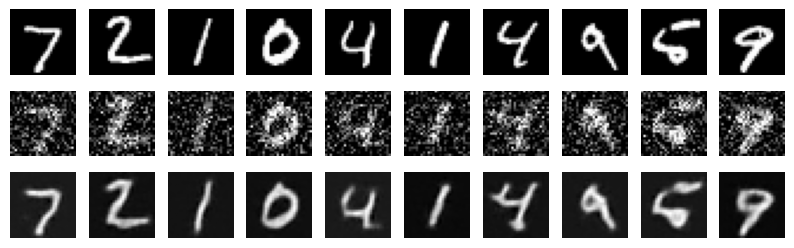

In [11]:
n = 10
plt.figure(figsize=(10, 3))

for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_test_images[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i].squeeze(), cmap="gray")
    plt.axis("off")

plt.show()